In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

X_train = download_data(r"/content/drive/MyDrive/Colab/Метод машинного обучения/lab4_data/train/images/")
Y_train = download_data(r"/content/drive/MyDrive/Colab/Метод машинного обучения/lab4_data/train/masks/")
X_test = download_data(r"/content/drive/MyDrive/Colab/Метод машинного обучения/lab4_data/test/images/")
Y_test = download_data(r"/content/drive/MyDrive/Colab/Метод машинного обучения/lab4_data/test/masks/")


In [6]:
palette = {0 : (60, 16, 152), # Building
           1 : (132, 41, 246), # Land
           2 : (110, 193, 228), # Road
           3 : (254, 221, 58), # Vegetation
           4 : (226, 169, 41), # Water
           5 : (155, 155, 155)} # Unlabeled

invert_palette = {v: k for k, v in palette.items()}

# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [7]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) 
    # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 
    # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) 
      # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] 
      # замена дистанции найденных элементов
      arr_2d[condition] = i 
      # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d


In [8]:
#X_train_pred = X_train/255
#X_test_pred = X_test/255
X_train_pred = np.array(X_train).reshape([7, 644, 796, 3])/255
X_test_pred = np.array(X_test).reshape([2, 644, 796, 3])/255
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [9]:
import numpy as np 
from keras.models import *
from keras.layers import *
from keras.optimizers import *

inputs = Input([644, 796, 3])
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, 5, activation = 'relu', padding = 'same')(pool1)
conv2 = Conv2D(64, 5, activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, 7, activation = 'relu', padding = 'same')(pool2)
conv3 = Conv2D(128, 7, activation = 'relu', padding = 'same')(conv3)

up1 = UpSampling2D(size = (2,2))(conv3)
merge1 = concatenate([conv2, up1], axis = 3)
conv4 = Conv2D(64, 5, activation = 'relu', padding = 'same')(merge1)
conv4 = Conv2D(64, 5, activation = 'relu', padding = 'same')(conv4)

up2 = UpSampling2D(size = (2,2))(conv4)
merge1 = concatenate([conv1, up2], axis = 3)
conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge1)
conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv5)

conv6 = Conv2D(6, 3, activation = 'softmax', padding = 'same')(conv5)

model = Model(inputs = inputs, outputs = conv6)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy')


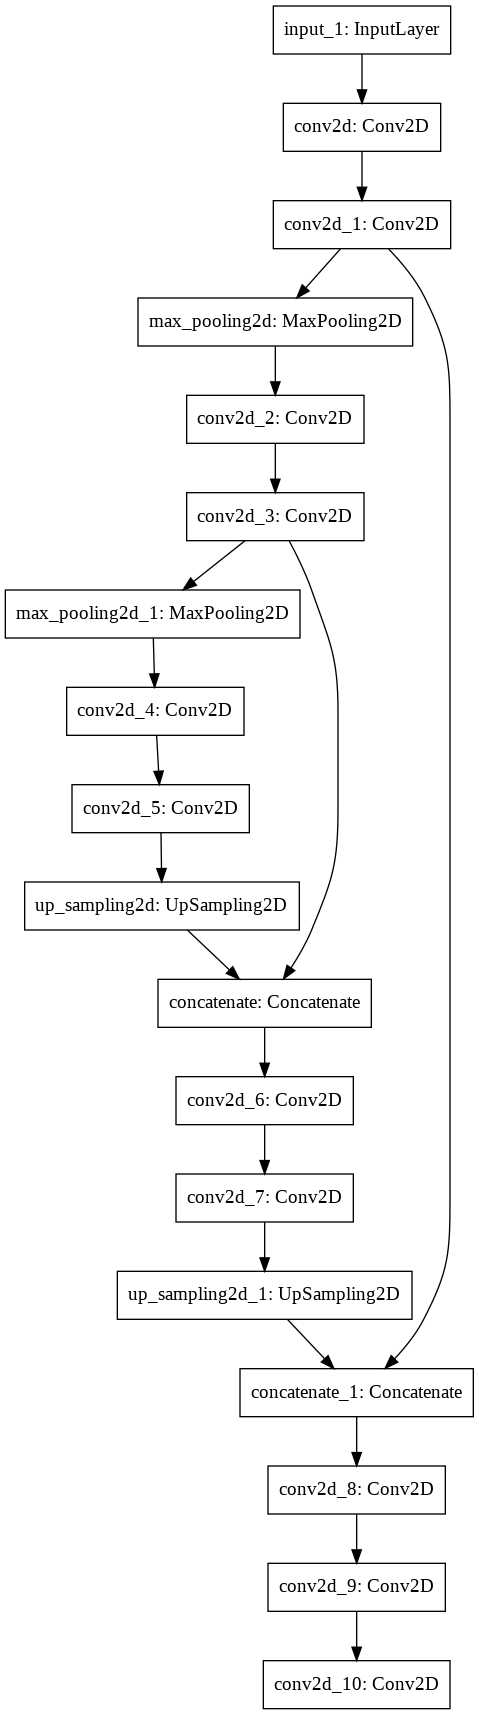

In [25]:
tf.keras.utils.plot_model(model)

In [10]:
model.fit(X_train_pred, Y_train_pred, batch_size=1, epochs=15)

Epoch 1/15
7/7 [==============================] - 157s 22s/step - loss: 1.3305
Epoch 2/15
7/7 [==============================] - 153s 22s/step - loss: 1.1326
Epoch 3/15
7/7 [==============================] - 153s 22s/step - loss: 1.0267
Epoch 4/15
7/7 [==============================] - 153s 22s/step - loss: 0.9818
Epoch 5/15
7/7 [==============================] - 153s 22s/step - loss: 0.9902
Epoch 6/15
7/7 [==============================] - 153s 22s/step - loss: 0.9651
Epoch 7/15
7/7 [==============================] - 153s 22s/step - loss: 0.9078
Epoch 8/15
7/7 [==============================] - 153s 22s/step - loss: 0.9060
Epoch 9/15
7/7 [==============================] - 153s 22s/step - loss: 0.8407
Epoch 10/15
7/7 [==============================] - 153s 22s/step - loss: 0.8463
Epoch 11/15
7/7 [==============================] - 153s 22s/step - loss: 0.8228
Epoch 12/15
7/7 [==============================] - 153s 22s/step - loss: 0.8009
Epoch 13/15
7/7 [==============================] 

In [11]:
model.evaluate(X_test_pred, Y_test_pred, batch_size=1)

2/2 [==============================] - 11s 5s/step - loss: 0.4914


0.4913598895072937

In [12]:
out = model.predict(X_test_pred, batch_size=1)

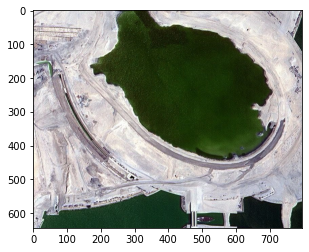

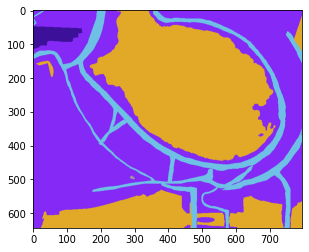

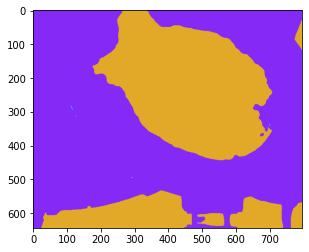

In [33]:
I = 0 # номер картинки после обработки нейронной сетью
plt.imshow(np.array(X_test)[I])
plt.show()
plt.imshow(np.array(Y_test)[I])
plt.show()
plt.imshow(convert_to_color(np.argmax(out[I], axis=-1)))
plt.show()